### 回帰分析

ここでは、教師あり学習のもう一つの分野である、回帰分析を詳しく見ていく。<br>
回帰モデルは、連続値をとる目的変数を予測するために使用される。<br>
例として、企業の今後数ヶ月間の売り上げを予測するために用いられる。<br>

<ul>
    <li>データセットの探索と可視化</li>
    <li>線形回帰モデルを実装するための各種アプローチの考察</li>
    <li>外れ値に対して頑健なモデルのトレーニング</li>
    <li>回帰モデルの評価と一般的な問題の診断</li>
    <li>回帰モデルの非線形データでの学習</li>
</ul>

### 単線形回帰

説明変数が一つの時のみ。<br>

### 重線形回帰

説明変数が多数存在。<br>

### Housingデータセットの探索

In [1]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/rasbt/'
                 'python-machine-learning-book-2nd-edition'
                 '/master/code/ch10/housing.data.txt',
                 header=None,
                 sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


### データセットの重要な特性を可視化する

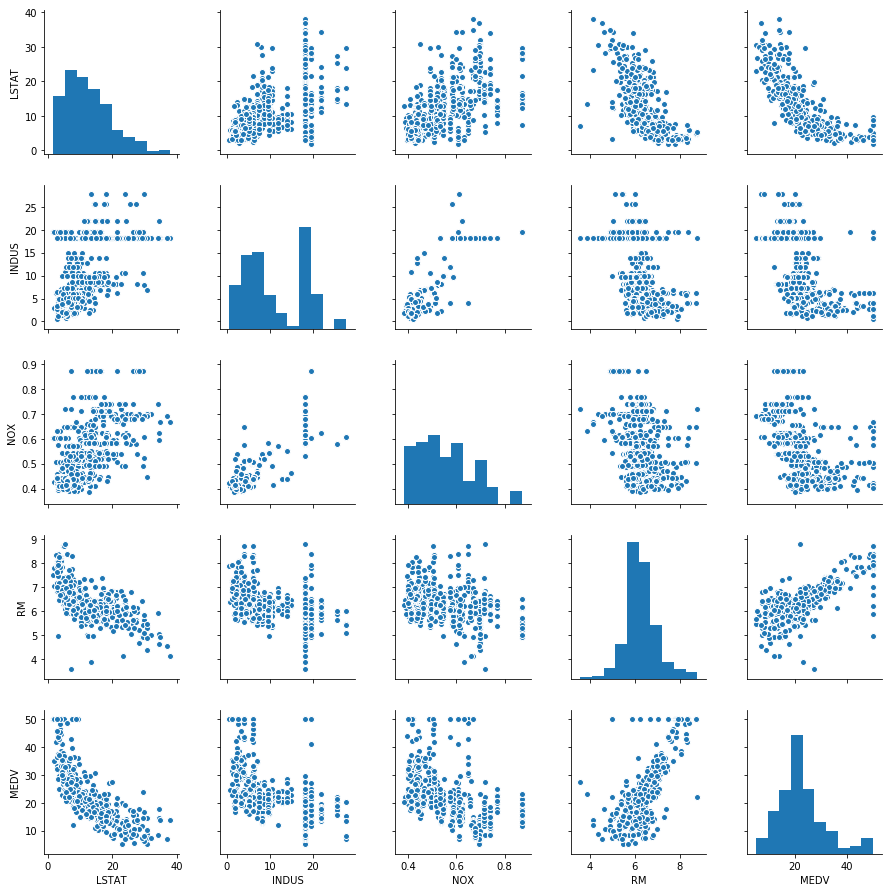

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
sns.pairplot(df[cols], size=2.5)
plt.tight_layout()
plt.show()

### 相関行列を使って関係を調べる

相関行列は共分散行列の尺度を取り直したバージョンである。<br>

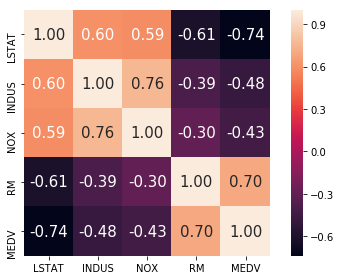

In [3]:
import numpy as np
cm = np.corrcoef(df[cols].values.T) # ピアソンの積率相関係数を計算
hm = sns.heatmap(
    cm, # ヒートマップを作成
    cbar=True, # カラーバーの表示
    annot=True, # データ値の表示
    square=True, # 正方形化
    fmt='.2f', # 数値などの表示
    annot_kws={'size': 15}, # データ値のサイズの設定
    yticklabels=cols, # 行の目盛のラベル名
    xticklabels=cols # 列の目盛のラベル名
)
plt.tight_layout()
plt.show()

線形回帰モデルを適合させるにあたって着目すべきは、<br>
目的変数であるMEDV（住宅価格の中央値）との相関が高い特徴量である。<br>
MEDV変数との相関がもっとも高いのは、LSTAT変数であることがわかる。<br>
一方で、RMとMEDVの間の相関も比較的高いことがわかる。<br>
以上から、RMは単回帰分析に用いる説明変数としてうってつけに思える。<br>
そこで次節からは、単回帰モデルの概念を紹介する。<br>

### 最小二乗線形回帰モデルの実装

線形回帰とは「トレーニングデータのサンプル点を通過する直線のうち、もっとも適合するものを取得すること」とある。<br>
だが、今までは「もっとも適合する」が意味するもの、そうしたモデルを学習させる手法についてもまだ説明していない。<br>
以下の項では、最小二乗法を用いることで、欠けているピースを埋めていく。<br>

### 勾配降下法を使って回帰パラメータの回帰を解く

ADALINEの実装について考えてみる。<br>
人工ニューロンが線形活性化関数を使用すること、コスト関数$J$を定義した。<br>
その際には、勾配降下法（GD）や確率的勾配降下法（SGD）といった最適化アルゴリズムを用いて、<br>
コスト関数を最小化する重みを学習した。<br>
このADALINEのコスト関数は誤差平方和である。<br>

最初に基本的な線形回帰モデルを実装する。<br>

In [4]:
# 基本的な線形回帰モデル
class LinearRegressionGD(object):
    # 初期化を実行する__init__
    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta # 学習率
        self.n_iter = n_iter # トレーニング回数
        
    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1]) # 重みを初期化
        self.cost_ = [] # コスト関数の値を初期化
        for i in range(self.n_iter): 
            output = self.net_input(X) # 活性化関数の出力を計算
            errors = (y-output) # 誤差を計算
            self.w_[1:] += self.eta * X.T.dot(errors) # 重みw_{1}以降を更新
            self.w_[0] = self.eta * errors.sum() # 重みw_{0}を更新
            cost = (errors**2).sum() / 2.0 # コスト関数を計算
            self.cost_.append(cost) # コスト関数の値を格納
        return self
    
    # 総入力を計算するnet_input
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    # 予測値を計算するpredict
    def predict(self, X):
        return self.net_input(X)

基本的な線形回帰モデルであるLinearRegressionGD回機器の実際の動作を確認するために、<br>
HousingデータセットのMEDVを予測するモデルをトレーニングする。<br>
ここで説明変数として、RMを使用する。<br>

In [19]:
X = df[['RM']].values
y = df['MEDV'].values
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()
lr = LinearRegressionGD()
lr.fit(X_std, y_std)